In [1]:
from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

wandb_run_id = init_wandb(run_name="features_engineering")
print(f"Run ID {wandb_run_id}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/valeriya/.netrc.
wandb: Currently logged in as: vslovik (homeserve) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run ID eanfb7e5



📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 10.7 seconds
⚠️  10.7s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical quotes: 7,105
   Non-conver

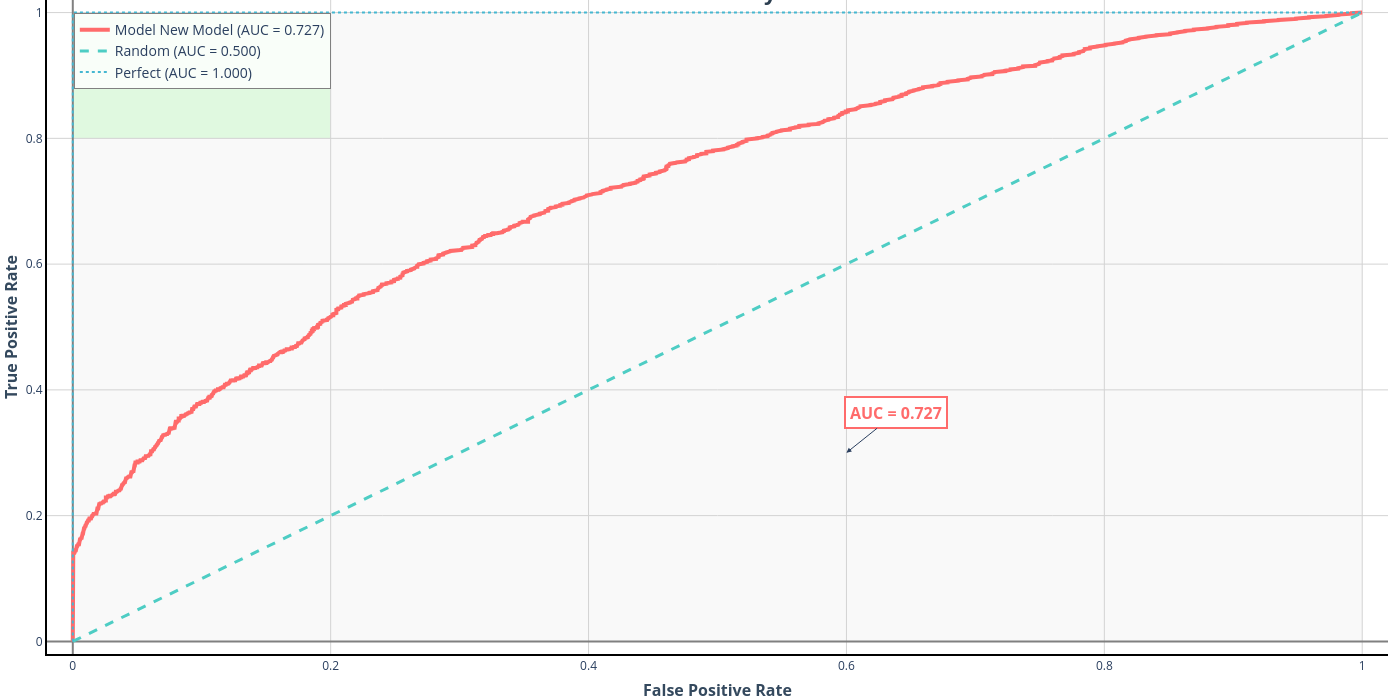

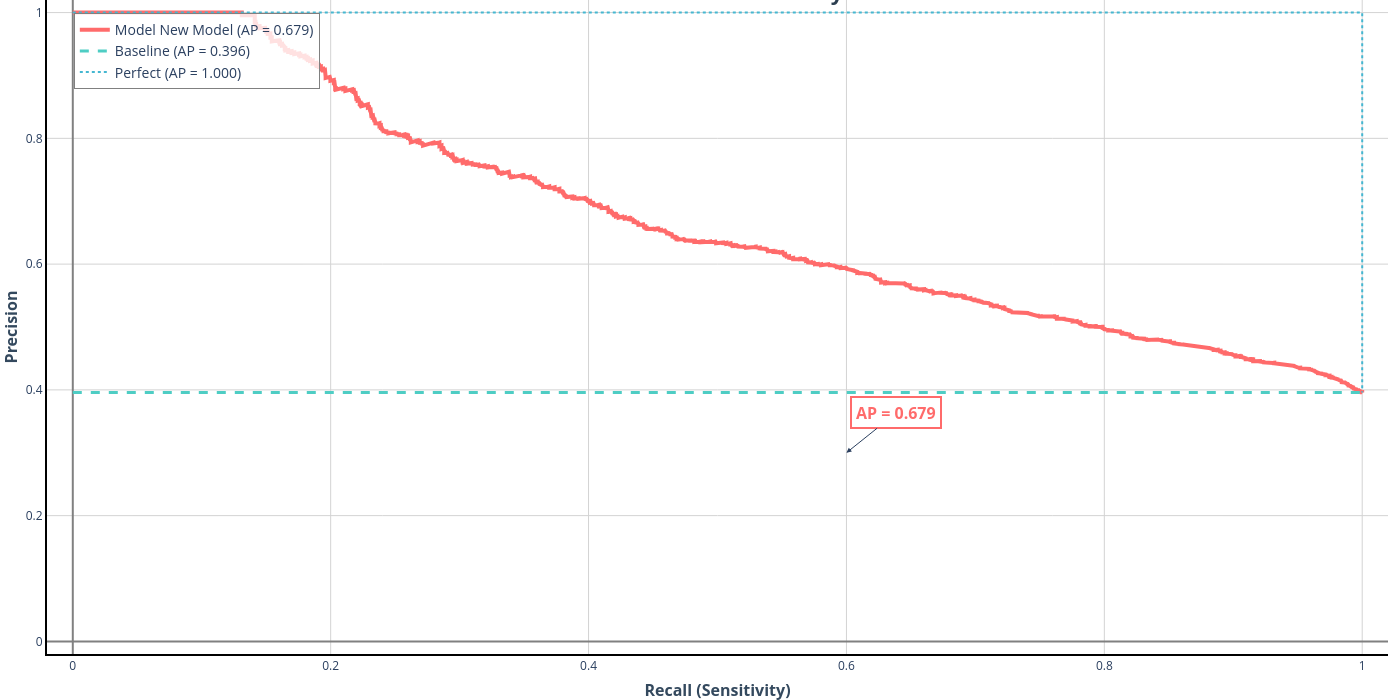

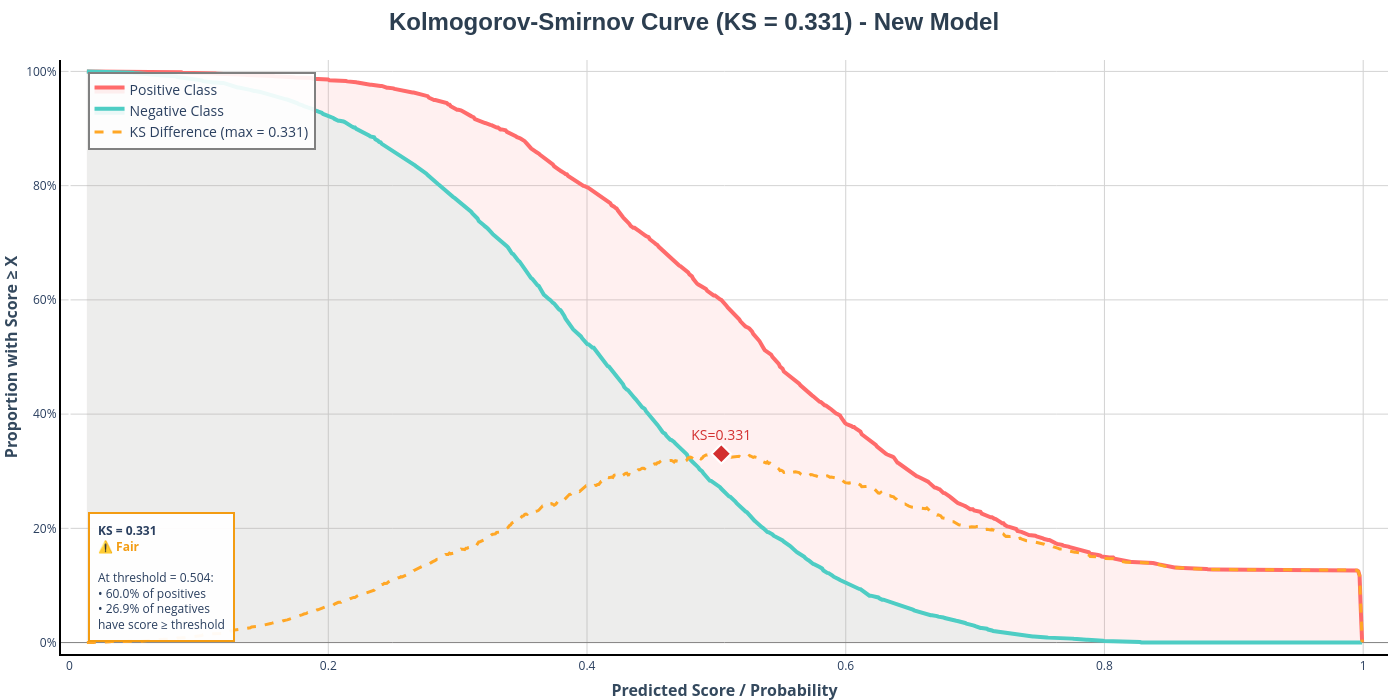

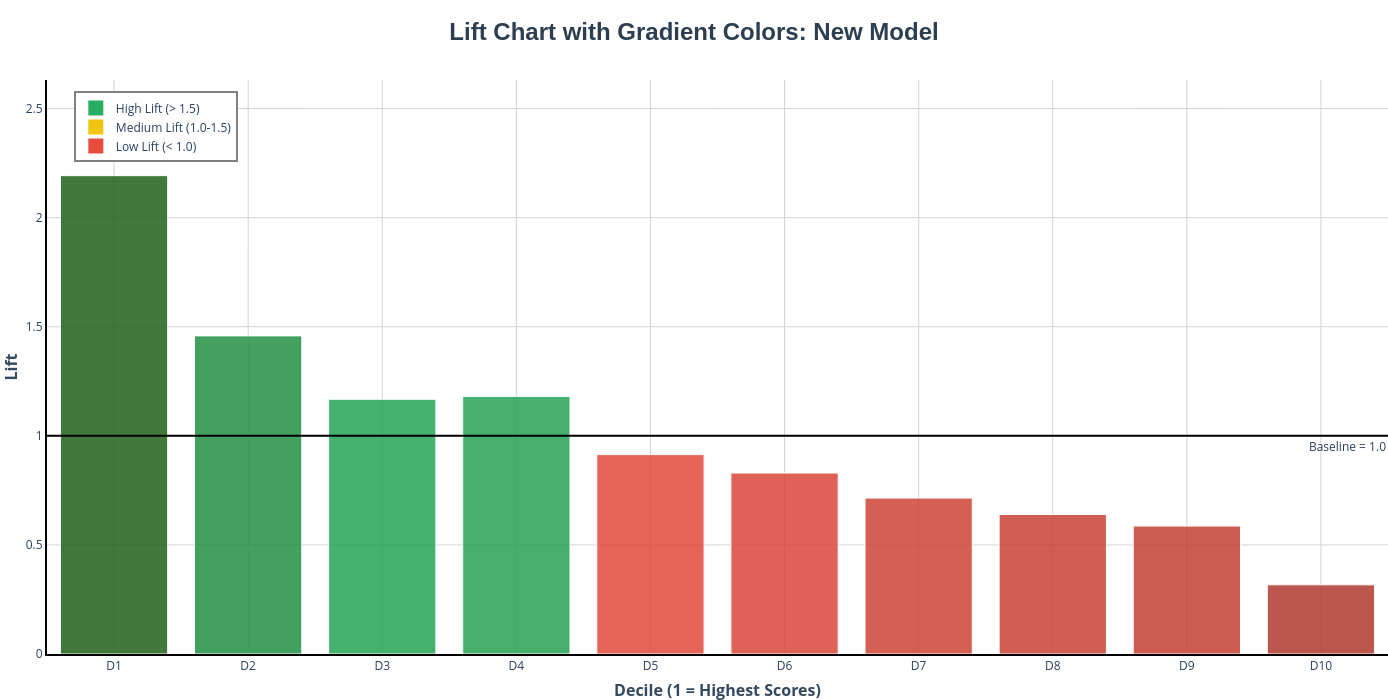

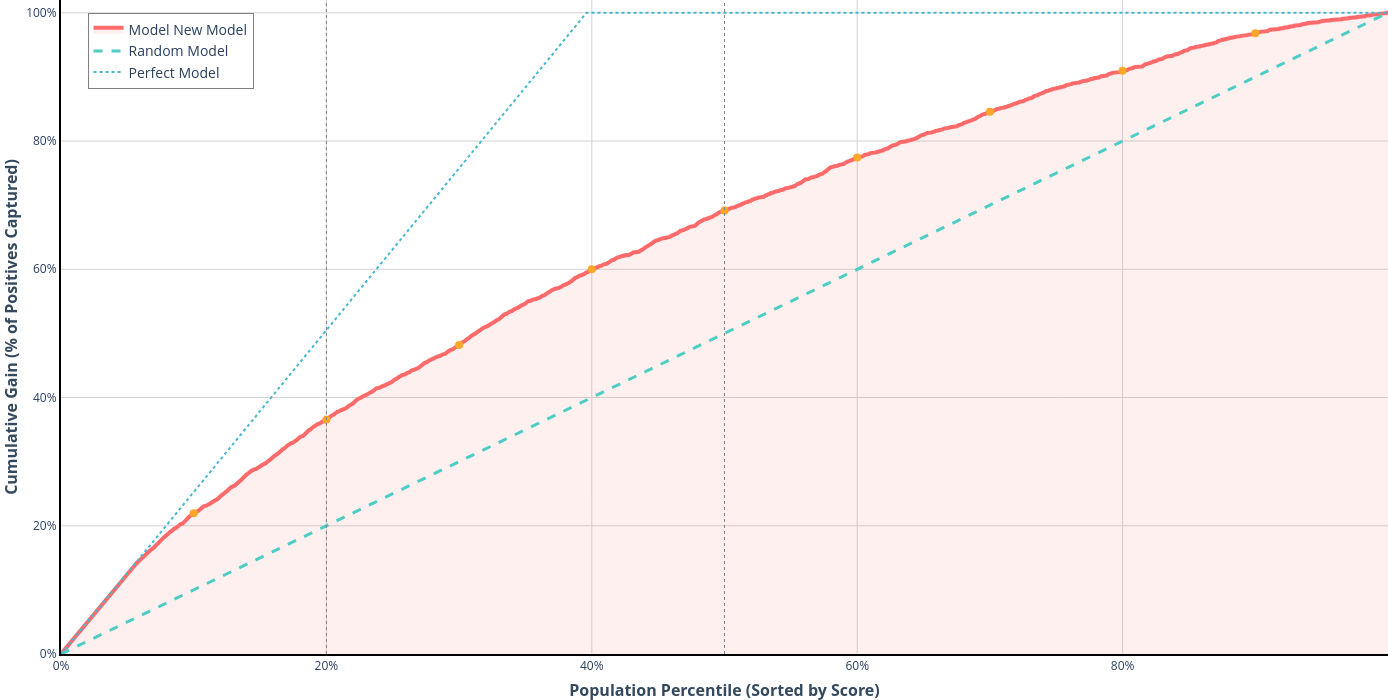

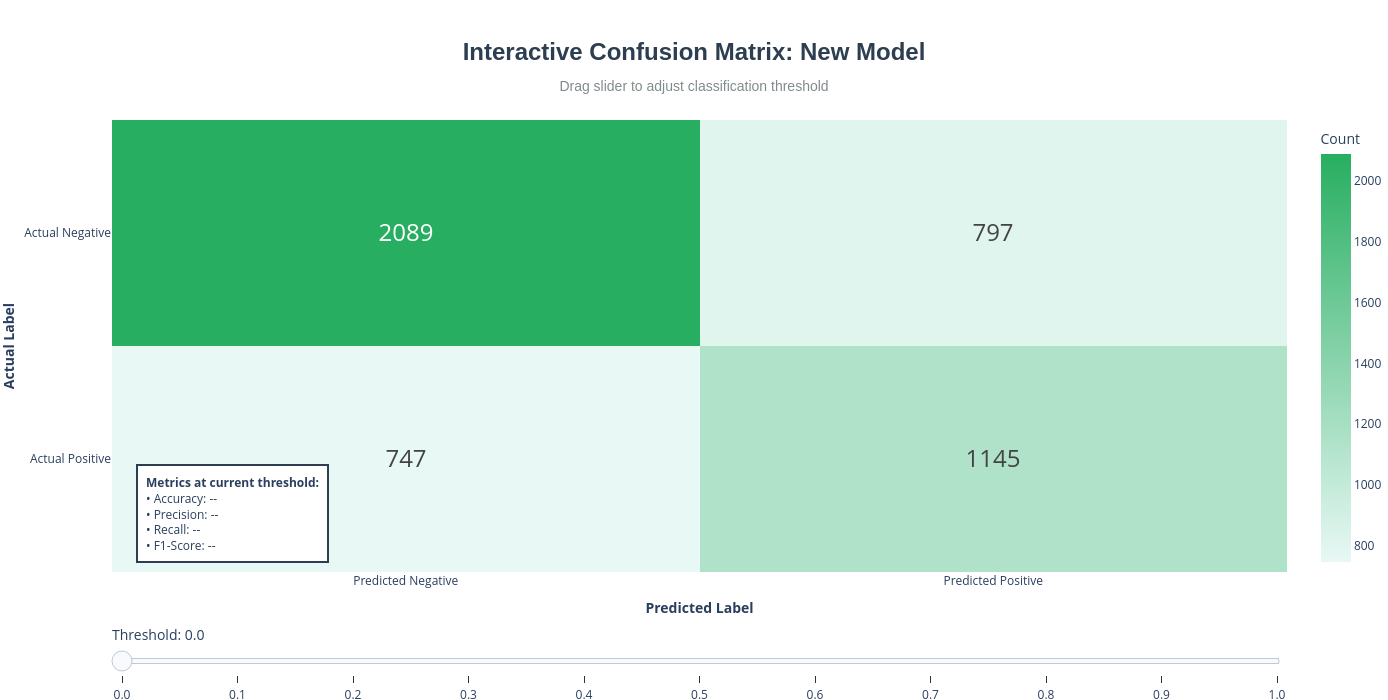

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_features.correction_features import create_correction_features
from ml_features.catboost_interaction_features import create_catboost_interaction_features
from ml_features.efficiency_interation_features import create_efficiency_interaction_features
from ml_features.engagement_interation_features import create_engagement_interaction_features
from ml_training.train_xgb import train_xgb
from ml_evaluation.dashboard import model_evaluation_report
from ml_evaluation.error_analysis import comprehensive_error_analysis, analyze_feature_contribution_to_errors, create_error_visualization

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE FEATURES")
print("="*80)


# Create feature list
feature_funcs = [create_customer_features, create_sequence_features, create_brand_features, 
                 create_model_features, create_market_features,
                 create_equipment_features, create_solution_complexity_features,
                 create_timeline_features, create_advanced_timeline_features,
                 create_commercial_role_features, create_process_features
                 , create_correction_features
                ]


new_df = feature_funcs[0](df_quotes)
customer_df = new_df
for func in feature_funcs[1:]:
    new_df_ = func(df_quotes)

    new_df = pd.merge(new_df, new_df_, on='numero_compte', how='left', suffixes=('_dup', ''))
    new_df = new_df.drop(columns=[x for x in new_df.columns if '_dup' in x], errors='ignore')
    print(len(new_df))
    if func == create_sequence_features: sequence_df = new_df


# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")

new_df = create_timeline_interaction_features(new_df)
new_df, _ = create_catboost_interaction_features(new_df)
new_df, _ = create_efficiency_interaction_features(new_df)
new_df, _ = create_engagement_interaction_features(new_df)

X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")

print("\n" + "="*80)
print("MODEL TRAINING WITH PROPER VISUALIZATIONS")
print("="*80)

# Test 1: Customer features
print("\n🧪 CUSTOMER FEATURES MODEL")
result_customer = train_xgb(X_customer_clean, y_customer_clean, 'customer_model')

# Create predictions for visualizations
X_test_customer = result_customer['X_test']
y_test_customer = result_customer['y_test']
y_pred_customer = result_customer['model'].predict(X_test_customer)
y_pred_proba_customer = result_customer['model'].predict_proba(X_test_customer)[:, 1]

# plots = log_all_plots(y_test, y_pred_proba, wandb_run_id, "Base Customer Model")
# for k, plot in plots.items():
#     plot.show()

# Test 2: Sequence features
print("\n🧪 SEQUENCE FEATURES MODEL")
result_sequence = train_xgb(X_sequence_clean, y_sequence_clean, 'sequence_model')
X_test_seq = result_sequence['X_test']
y_test_seq = result_sequence['y_test']
y_pred_seq = result_sequence['model'].predict(X_test_seq)
y_pred_proba_seq = result_sequence['model'].predict_proba(X_test_seq)[:, 1]

# plots = log_all_plots(y_test_seq, y_pred_proba_seq, wandb_run_id, "Sequence Model")
# for k, plot in plots.items():
#     plot.show()

# Test 3: Sequence features
print("\n🧪 NEW FEATURES MODEL")
result_new = train_xgb(X_new_clean, y_new_clean, 'new_model')
X_test_new = result_new['X_test']
y_test_new = result_new['y_test']
y_pred_new = result_new['model'].predict(X_test_new)
y_pred_proba_new = result_new['model'].predict_proba(X_test_new)[:, 1]

plots = log_all_plots(y_test_new, y_pred_proba_new, wandb_run_id, "New Model")
for k, plot in plots.items():
    plot.show()

In [3]:
import matplotlib.pyplot as plt
# Create comparison bar chart (only one extra chart)
print("\n📊 CREATING MODEL COMPARISON")
fig, ax = plt.subplots(figsize=(8, 6))
models = ['Customer', 'Sequence', 'New']

auc_customer = roc_auc_score(y_test_customer, y_pred_proba_customer)
auc_sequence = roc_auc_score(y_test_seq, y_pred_proba_seq)
auc_new = roc_auc_score(y_test_new, y_pred_proba_new)
aucs = [auc_customer, auc_sequence, auc_new]

bars = ax.bar(models, aucs, color=['skyblue', 'lightcoral'])
ax.set_ylabel('AUC Score')
ax.set_title('Model AUC Comparison')
ax.set_ylim([0, 1])

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc:.3f}', ha='center', va='bottom')


log_plot_as_image(fig, wandb_run_id, "model_comparison")
fig.show()
plt.close(fig)


print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"Customer Model AUC: {auc_customer:.3f}")
print(f"Sequence Model AUC: {auc_sequence:.3f}")
print(f"Improvement: {auc_sequence - auc_customer:.3f}")
print(f"New Model AUC: {auc_new:.3f}")
print(f"Improvement: {auc_new - auc_customer:.3f}")


📊 CREATING MODEL COMPARISON



RESULTS SUMMARY
Customer Model AUC: 0.647
Sequence Model AUC: 0.668
Improvement: 0.021
New Model AUC: 0.727
Improvement: 0.080
